In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
import nibabel as nib
im = nib.load("UpsampledSegments/C4LinearUpsampled0p2mm.nii.gz")
Linear0p2 = np.int8(im.get_fdata())
im = nib.load("UpsampledSegments/C4LinearUpsampled0p5mm.nii.gz")
Linear0p5 = np.int8(im.get_fdata())
im = nib.load("UpsampledSegments/C4MeshUpsampled0p2mm.nii.gz")
Mesh0p2 = np.int8(im.get_fdata())
im = nib.load("UpsampledSegments/C4MeshUpsampled0p5mm.nii.gz")
Mesh0p5 = np.int8(im.get_fdata())
im = nib.load("UpsampledSegments/C4NNUpsampled0p2mm.nii.gz")
NN0p2 = np.int8(im.get_fdata())
im = nib.load("UpsampledSegments/C4NNUpsampled0p5mm.nii.gz")
NN0p5 = np.int8(im.get_fdata())
im = nib.load("UpsampledSegments/newC4HalfGroundTruth.nii.gz")
GroundTruth = np.int8(im.get_fdata())

In [3]:
ROI = np.load("ROIs/erode_C4ROI3D.npy")
GTfocused = np.load("3Dresults/3Dsimulation_GroundTruth_0p2mm_focused_onepulse.npy")
Linear0p2r = np.load("3Dresults/3Dsimulation_Linear_0p2mm_focused_onepulse.npy")
Linear0p5r = np.load("3Dresults/3Dsimulation_Linear_0p5mm_focused_onepulse.npy")
NN0p2r = np.load("3Dresults/3Dsimulation_NN_0p2mm_focused_onepulse.npy")
NN0p5r = np.load("3Dresults/3Dsimulation_NN_0p5mm_focused_onepulse.npy")
Mesh0p2r = np.load("3Dresults/3Dsimulation_Mesh_0p2mm_focused_onepulse.npy")
Mesh0p5r = np.load("3Dresults/3Dsimulation_Mesh_0p5mm_focused_onepulse.npy")

R_GT = np.full(ROI.shape, np.nan, dtype=float)
R_GT[ROI>0] = GTfocused

R_Linear0p2 = np.full(ROI.shape, np.nan, dtype=float)
R_Linear0p2[ROI>0] = Linear0p2r
R_Linear0p5 = np.full(ROI.shape, np.nan, dtype=float)
R_Linear0p5[ROI>0] = Linear0p5r

R_NN0p2 = np.full(ROI.shape, np.nan, dtype=float)
R_NN0p2[ROI>0] = NN0p2r
R_NN0p5 = np.full(ROI.shape, np.nan, dtype=float)
R_NN0p5[ROI>0] = NN0p5r

R_Mesh0p2 = np.full(ROI.shape, np.nan, dtype=float)
R_Mesh0p2[ROI>0] = Mesh0p2r
R_Mesh0p5 = np.full(ROI.shape, np.nan, dtype=float)
R_Mesh0p5[ROI>0] = Mesh0p5r

In [4]:
from scipy.ndimage import binary_erosion
from scipy.ndimage import zoom

def nearest_resample(v, factor):
    upsampled = zoom(v, zoom=factor, order=0)
    return (upsampled > 0.5).astype(np.uint8)

def linear_resample(v, factor):
    upsampled = zoom(v.astype(float), zoom=factor, order=1)
    return (upsampled > 0.5).astype(np.uint8)
    
def morphological_downsample(v, factor):
    eroded = binary_erosion(v)
    return nearest_resample(eroded, factor)

downsampled_volume_0p5mm =  morphological_downsample(np.float32(GroundTruth), factor=0.2)
downsampled_volume_0p2mm =  morphological_downsample(np.float32(GroundTruth), factor=0.5)

downsampled_volume_0p5mm = np.float32(downsampled_volume_0p5mm)
downsampled_volume_0p2mm = np.float32(downsampled_volume_0p2mm)

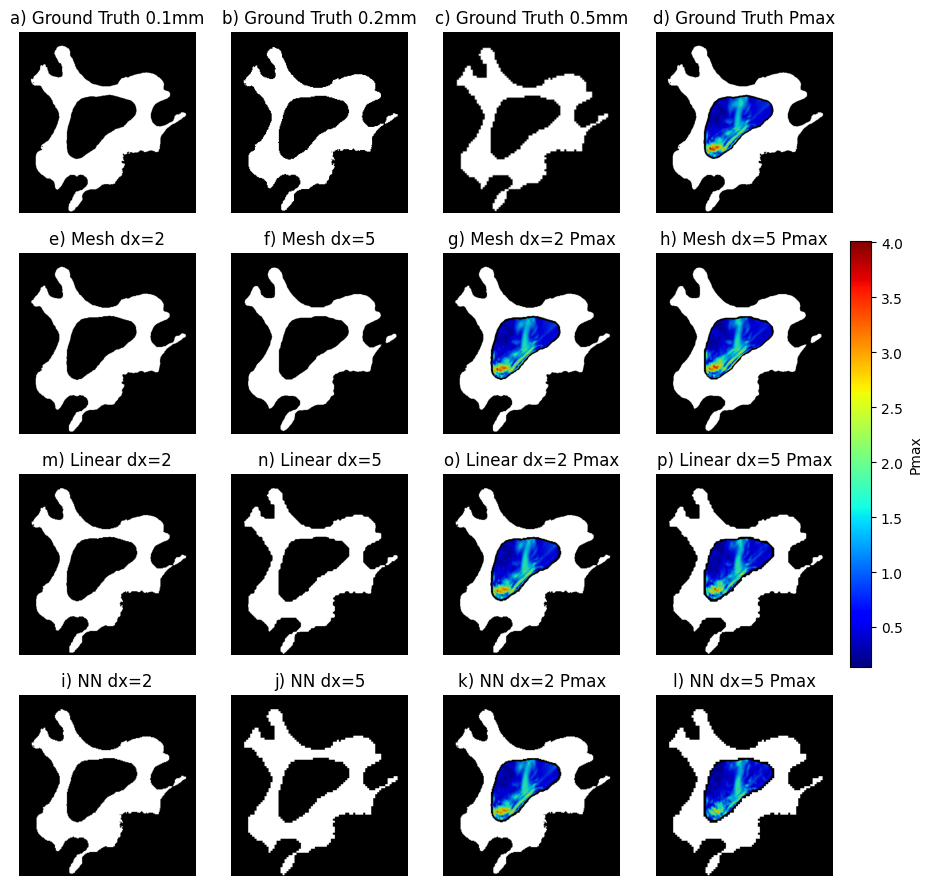

In [5]:
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

slice_idx = 101
plt.figure(figsize=(11, 11))

slice_pmax_arrays = [
    R_GT[:, :, slice_idx],
    R_Mesh0p2[:, :, slice_idx],
    R_Mesh0p5[:, :, slice_idx],
    R_NN0p2[:, :, slice_idx],
    R_NN0p5[:, :, slice_idx],
    R_Linear0p2[:, :, slice_idx],
    R_Linear0p5[:, :, slice_idx],
]

# concatenate valid (non-NaN) values only
all_pmax_vals = np.concatenate([
    a[np.isfinite(a)] for a in slice_pmax_arrays
])

pmin = np.min(all_pmax_vals)
pmax = np.max(all_pmax_vals)

norm_p = Normalize(vmin=pmin, vmax=pmax)

# ---------- Row 1: Ground truth ----------
plt.subplot(4, 4, 1)
plt.imshow(GroundTruth[:, :, slice_idx], cmap='gray')
plt.title('a) Ground Truth 0.1mm')
plt.axis('off')

plt.subplot(4, 4, 2)
plt.imshow(downsampled_volume_0p2mm[:, :, slice_idx // 2], cmap='gray')
plt.title('b) Ground Truth 0.2mm')
plt.axis('off')

plt.subplot(4, 4, 3)
plt.imshow(downsampled_volume_0p5mm[:, :, slice_idx // 5], cmap='gray')
plt.title('c) Ground Truth 0.5mm')
plt.axis('off')

plt.subplot(4, 4, 4)
plt.imshow(GroundTruth[:, :, slice_idx], cmap='gray')
plt.imshow(R_GT[:, :, slice_idx], cmap='jet', norm=norm_p, alpha=0.85)
plt.title('d) Ground Truth Pmax')
plt.axis('off')

# ---------- Row 2: Mesh ----------
plt.subplot(4, 4, 5)
plt.imshow(Mesh0p2[:, :, slice_idx], cmap='gray')
plt.title('e) Mesh dx=2')
plt.axis('off')

plt.subplot(4, 4, 6)
plt.imshow(Mesh0p5[:, :, slice_idx], cmap='gray')
plt.title('f) Mesh dx=5')
plt.axis('off')

plt.subplot(4, 4, 7)
plt.imshow(Mesh0p2[:, :, slice_idx], cmap='gray')
plt.imshow(R_Mesh0p2[:, :, slice_idx], cmap='jet', norm=norm_p, alpha=0.85)
plt.title('g) Mesh dx=2 Pmax')
plt.axis('off')

plt.subplot(4, 4, 8)
plt.imshow(Mesh0p5[:, :, slice_idx], cmap='gray')
plt.imshow(R_Mesh0p5[:, :, slice_idx], cmap='jet', norm=norm_p, alpha=0.85)
plt.title('h) Mesh dx=5 Pmax')
plt.axis('off')

# ---------- Row 3: NN ----------
plt.subplot(4, 4, 13)
plt.imshow(NN0p2[:, :, slice_idx], cmap='gray')
plt.title('i) NN dx=2')
plt.axis('off')

plt.subplot(4, 4, 14)
plt.imshow(NN0p5[:, :, slice_idx], cmap='gray')
plt.title('j) NN dx=5')
plt.axis('off')

plt.subplot(4, 4, 15)
plt.imshow(NN0p2[:, :, slice_idx], cmap='gray')
plt.imshow(R_NN0p2[:, :, slice_idx], cmap='jet', norm=norm_p, alpha=0.85)
plt.title('k) NN dx=2 Pmax')
plt.axis('off')

plt.subplot(4, 4, 16)
plt.imshow(NN0p5[:, :, slice_idx], cmap='gray')
plt.imshow(R_NN0p5[:, :, slice_idx], cmap='jet', norm=norm_p, alpha=0.85)
plt.title('l) NN dx=5 Pmax')
plt.axis('off')

# ---------- Row 4: Linear ----------
plt.subplot(4, 4, 9)
plt.imshow(Linear0p2[:, :, slice_idx], cmap='gray')
plt.title('m) Linear dx=2')
plt.axis('off')

plt.subplot(4, 4, 10)
plt.imshow(Linear0p5[:, :, slice_idx], cmap='gray')
plt.title('n) Linear dx=5')
plt.axis('off')

plt.subplot(4, 4, 11)
plt.imshow(Linear0p2[:, :, slice_idx], cmap='gray')
plt.imshow(R_Linear0p2[:, :, slice_idx], cmap='jet', norm=norm_p, alpha=0.85)
plt.title('o) Linear dx=2 Pmax')
plt.axis('off')

plt.subplot(4, 4, 12)
plt.imshow(Linear0p5[:, :, slice_idx], cmap='gray')
plt.imshow(R_Linear0p5[:, :, slice_idx], cmap='jet', norm=norm_p, alpha=0.85)
plt.title('p) Linear dx=5 Pmax')
plt.axis('off')

# ---------- Shared Pmax colorbar ----------
sm = ScalarMappable(norm=norm_p, cmap='jet')
sm.set_array([])

cbar = plt.colorbar(
    sm,
    ax=plt.gcf().axes,
    fraction=0.025,
    pad=0.02
)
cbar.set_label('Pmax')

plt.savefig("visual_comparsion_all+Pmax.svg", dpi=300, bbox_inches='tight')
plt.show()
